/var/folders/n2/729vncyx06jfhjr9v_2qc25r0000gn/T/ipykernel_15416/3587306851.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start=start_date, end=end_date, freq='30T')
/var/folders/n2/729vncyx06jfhjr9v_2qc25r0000gn/T/ipykernel_15416/3587306851.py:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_swin = swin_df['SWin'].resample('M').mean()


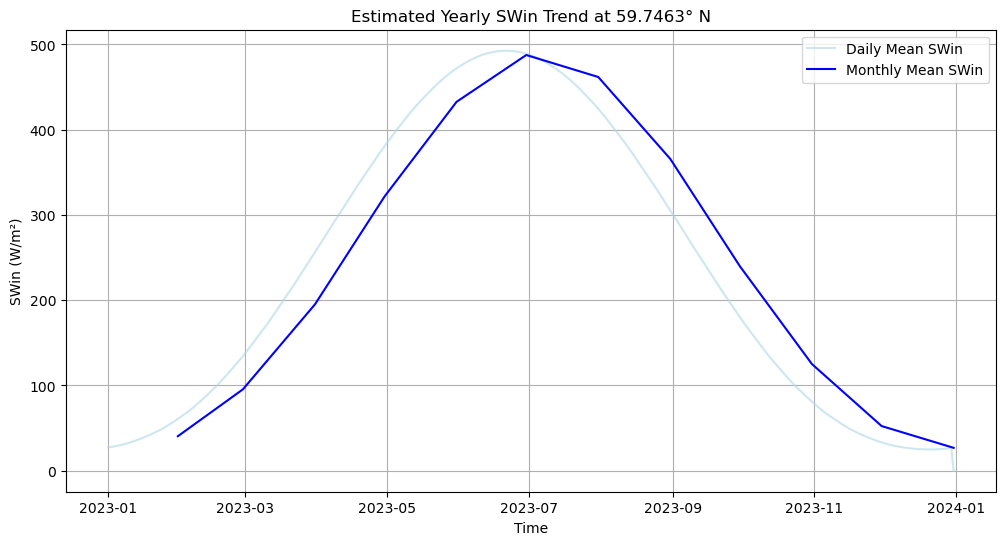

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Constants
latitude = 59.7463  # Latitude in degrees
longitude = 8.8083  # Longitude in degrees (not needed for daily cycle but helpful if extending this)
solar_constant = 1361  # Solar constant in W/m²

# Generate a time series for the year with 30-minute intervals
start_date = datetime(2023, 1, 1)  # Example year
end_date = datetime(2023, 12, 31)
time_index = pd.date_range(start=start_date, end=end_date, freq='30T')

# Solar declination function
def solar_declination(day_of_year):
    # Approximation of the solar declination angle in radians
    return 23.44 * np.pi / 180 * np.sin(2 * np.pi * (284 + day_of_year) / 365)

# Calculate SWin
swin_series = []
for timestamp in time_index:
    # Day of the year and time in hours
    day_of_year = timestamp.timetuple().tm_yday
    hour_angle = (timestamp.hour + timestamp.minute / 60 - 12) * 15 * np.pi / 180  # in radians
    
    # Calculate solar zenith angle
    declination = solar_declination(day_of_year)
    latitude_rad = np.radians(latitude)
    
    # Solar zenith angle calculation
    cos_zenith_angle = (
        np.sin(latitude_rad) * np.sin(declination) +
        np.cos(latitude_rad) * np.cos(declination) * np.cos(hour_angle)
    )
    cos_zenith_angle = max(0, cos_zenith_angle)  # No radiation when the sun is below the horizon
    
    # Estimate SWin using the solar constant and cosine of zenith angle
    swin = solar_constant * cos_zenith_angle
    swin_series.append(swin)

# Create a DataFrame for analysis and plotting
swin_df = pd.DataFrame(data={'SWin': swin_series}, index=time_index)

# Resample to daily and monthly averages for a smoother trend
daily_swin = swin_df['SWin'].resample('D').mean()
monthly_swin = swin_df['SWin'].resample('M').mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_swin.index, daily_swin, label='Daily Mean SWin', color='lightblue', alpha=0.6)
plt.plot(monthly_swin.index, monthly_swin, label='Monthly Mean SWin', color='blue')
plt.xlabel('Time')
plt.ylabel('SWin (W/m²)')
plt.title(f'Estimated Yearly SWin Trend at {latitude}° N')
plt.legend()
plt.grid()
plt.show()

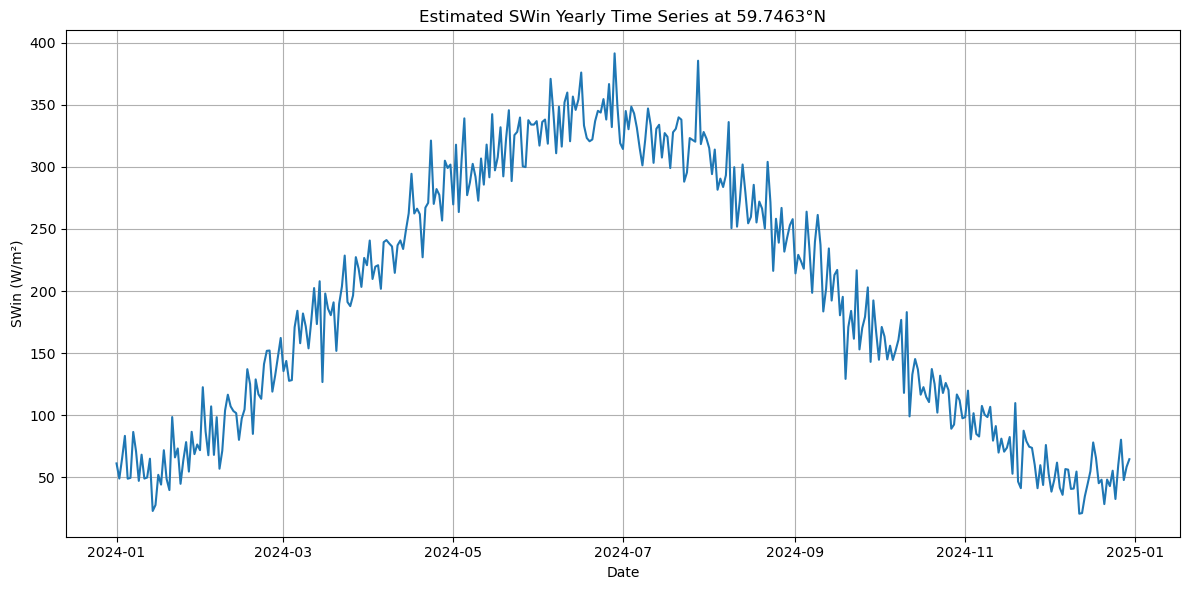

Minimum SWin: 20.60 W/m²
Maximum SWin: 391.50 W/m²
Mean SWin: 193.61 W/m²


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def estimate_swin(day_of_year, latitude):
    # Parameters for the sinusoidal function
    amplitude = 150  # W/m²
    mean = 200  # W/m²
    
    # Calculate base SWin using a sinusoidal function
    # Note the change here: we use cosine instead of sine to peak at day 172 (June 21st)
    swin = amplitude * np.cos(2 * np.pi * (day_of_year - 172) / 365) + mean
    
    # Adjust for latitude (simplified)
    lat_factor = np.cos(np.radians(latitude - 45))  # 45° as a reference latitude
    swin *= lat_factor
    
    # Ensure SWin is non-negative
    return max(swin, 0)

# Set up the time series
start_date = datetime(2024, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(365)]
days = [(date - start_date).days + 1 for date in dates]

# Generate SWin estimates
latitude = 59.7463
swin_estimates = [estimate_swin(day, latitude) for day in days]

# Add random variation to simulate day-to-day fluctuations
np.random.seed(42)  # For reproducibility
variation = np.random.normal(0, 20, 365)  # Mean 0, standard deviation 20 W/m²
swin_with_variation = np.clip(np.array(swin_estimates) + variation, 0, None)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(dates, swin_with_variation)
plt.title(f"Estimated SWin Yearly Time Series at {latitude}°N")
plt.xlabel("Date")
plt.ylabel("SWin (W/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Minimum SWin: {min(swin_with_variation):.2f} W/m²")
print(f"Maximum SWin: {max(swin_with_variation):.2f} W/m²")
print(f"Mean SWin: {np.mean(swin_with_variation):.2f} W/m²")

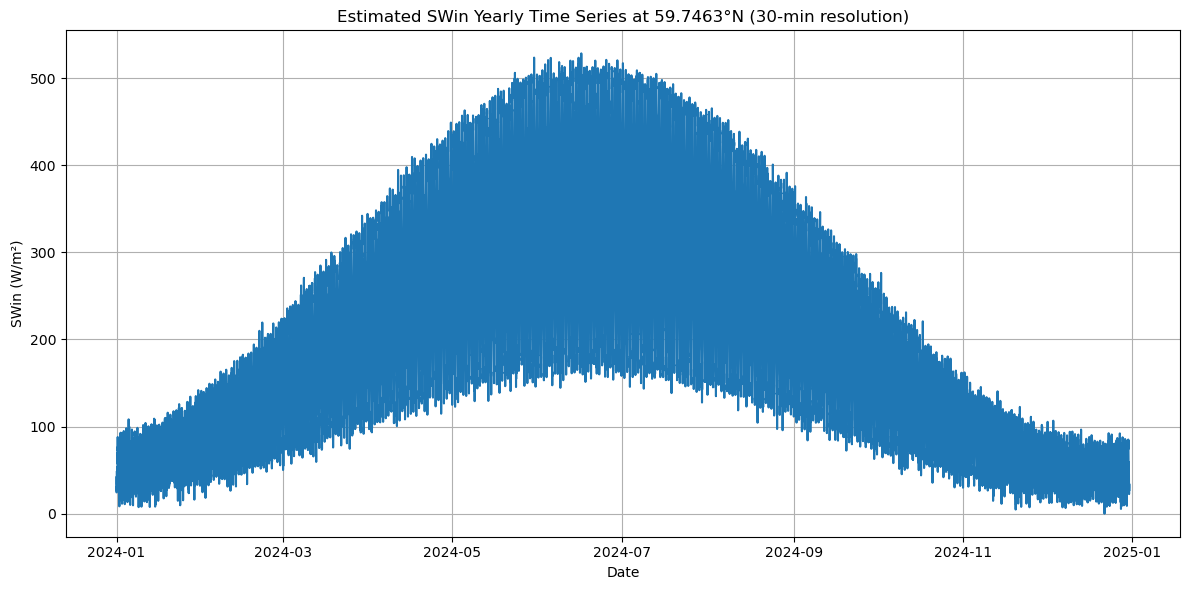

Minimum SWin: 0.00 W/m²
Maximum SWin: 528.29 W/m²
Mean SWin: 193.46 W/m²


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def estimate_swin(day_of_year, hour, latitude):
    # Parameters for the sinusoidal function
    amplitude = 150  # W/m²
    mean = 200  # W/m²
    
    # Calculate base SWin using a sinusoidal function for annual cycle
    annual_cycle = amplitude * np.cos(2 * np.pi * (day_of_year - 172) / 365) + mean
    
    # Add diurnal cycle (simplified)
    diurnal_amplitude = annual_cycle * 0.5  # Adjust this factor to change the strength of the diurnal cycle
    diurnal_cycle = diurnal_amplitude * np.sin(np.pi * hour / 12 - np.pi/2)
    
    swin = annual_cycle + diurnal_cycle
    
    # Adjust for latitude (simplified)
    lat_factor = np.cos(np.radians(latitude - 45))  # 45° as a reference latitude
    swin *= lat_factor
    
    # Ensure SWin is non-negative
    return max(swin, 0)

# Set up the time series
start_date = datetime(2024, 1, 1)
time_delta = timedelta(minutes=30)
dates = [start_date + i * time_delta for i in range(365 * 48)]  # 48 30-minute intervals per day

# Generate SWin estimates
latitude = 59.7463
swin_estimates = []

for date in dates:
    day_of_year = date.timetuple().tm_yday
    hour = date.hour + date.minute / 60
    swin_estimates.append(estimate_swin(day_of_year, hour, latitude))

# Add random variation to simulate fluctuations
np.random.seed(42)  # For reproducibility
variation = np.random.normal(0, 10, len(swin_estimates))  # Mean 0, standard deviation 10 W/m²
swin_with_variation = np.clip(np.array(swin_estimates) + variation, 0, None)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(dates, swin_with_variation)
plt.title(f"Estimated SWin Yearly Time Series at {latitude}°N (30-min resolution)")
plt.xlabel("Date")
plt.ylabel("SWin (W/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Minimum SWin: {min(swin_with_variation):.2f} W/m²")
print(f"Maximum SWin: {max(swin_with_variation):.2f} W/m²")
print(f"Mean SWin: {np.mean(swin_with_variation):.2f} W/m²")

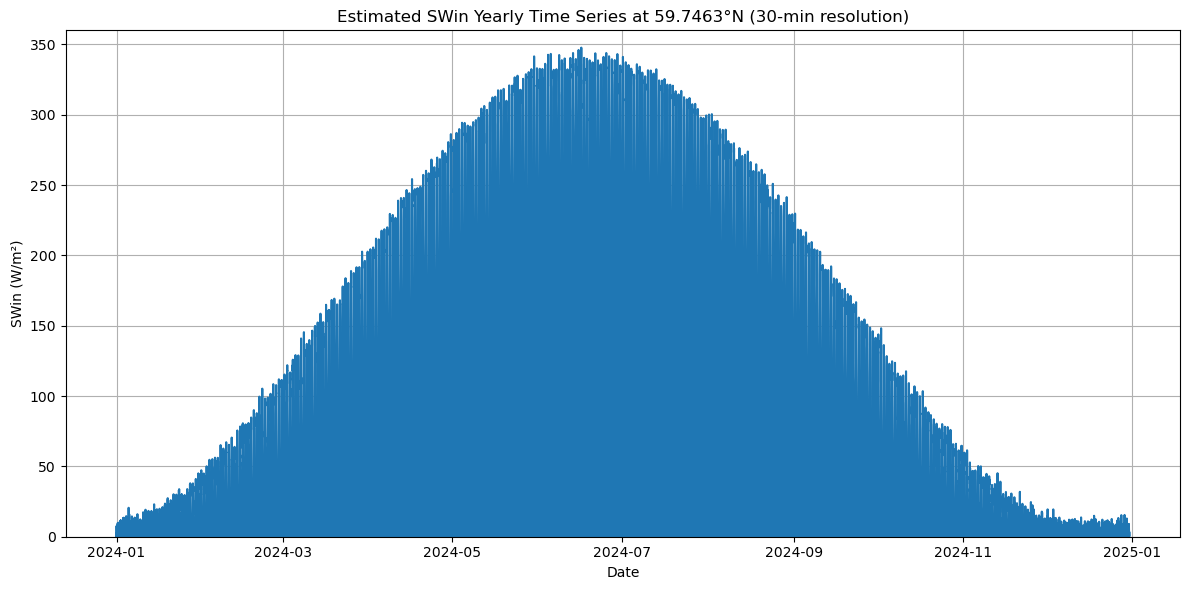

Minimum SWin: 0.00 W/m²
Maximum SWin: 347.71 W/m²
Mean SWin: 63.91 W/m²


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def estimate_swin(day_of_year, hour, latitude):
    # Parameters for the sinusoidal function
    max_swin = 350  # W/m²
    
    # Calculate base SWin using a sinusoidal function for annual cycle
    annual_factor = np.cos(2 * np.pi * (day_of_year - 172) / 365) * 0.5 + 0.5
    
    # Calculate sunrise and sunset times (simplified)
    day_length = 12 + 4 * np.sin(2 * np.pi * (day_of_year - 80) / 365)  # Approximate day length
    sunrise = 12 - day_length / 2
    sunset = 12 + day_length / 2
    
    # Diurnal cycle
    if sunrise <= hour <= sunset:
        diurnal_factor = np.sin(np.pi * (hour - sunrise) / (sunset - sunrise))
        swin = max_swin * annual_factor * diurnal_factor
    else:
        swin = 0
    
    # Adjust for latitude (simplified)
    lat_factor = np.cos(np.radians(latitude - 45))  # 45° as a reference latitude
    swin *= lat_factor
    
    return max(min(swin, 350), 0)  # Ensure SWin is between 0 and 350 W/m²

# Set up the time series
start_date = datetime(2024, 1, 1)
time_delta = timedelta(minutes=30)
dates = [start_date + i * time_delta for i in range(365 * 48)]  # 48 30-minute intervals per day

# Generate SWin estimates
latitude = 59.7463
swin_estimates = []

for date in dates:
    day_of_year = date.timetuple().tm_yday
    hour = date.hour + date.minute / 60
    swin_estimates.append(estimate_swin(day_of_year, hour, latitude))

# Add random variation to simulate fluctuations
np.random.seed(42)  # For reproducibility
variation = np.random.normal(0, 5, len(swin_estimates))  # Mean 0, standard deviation 5 W/m²
swin_with_variation = np.clip(np.array(swin_estimates) + variation, 0, 350)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(dates, swin_with_variation)
plt.title(f"Estimated SWin Yearly Time Series at {latitude}°N (30-min resolution)")
plt.xlabel("Date")
plt.ylabel("SWin (W/m²)")
plt.ylim(0, 360)  # Set y-axis limits
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Minimum SWin: {min(swin_with_variation):.2f} W/m²")
print(f"Maximum SWin: {max(swin_with_variation):.2f} W/m²")
print(f"Mean SWin: {np.mean(swin_with_variation):.2f} W/m²")

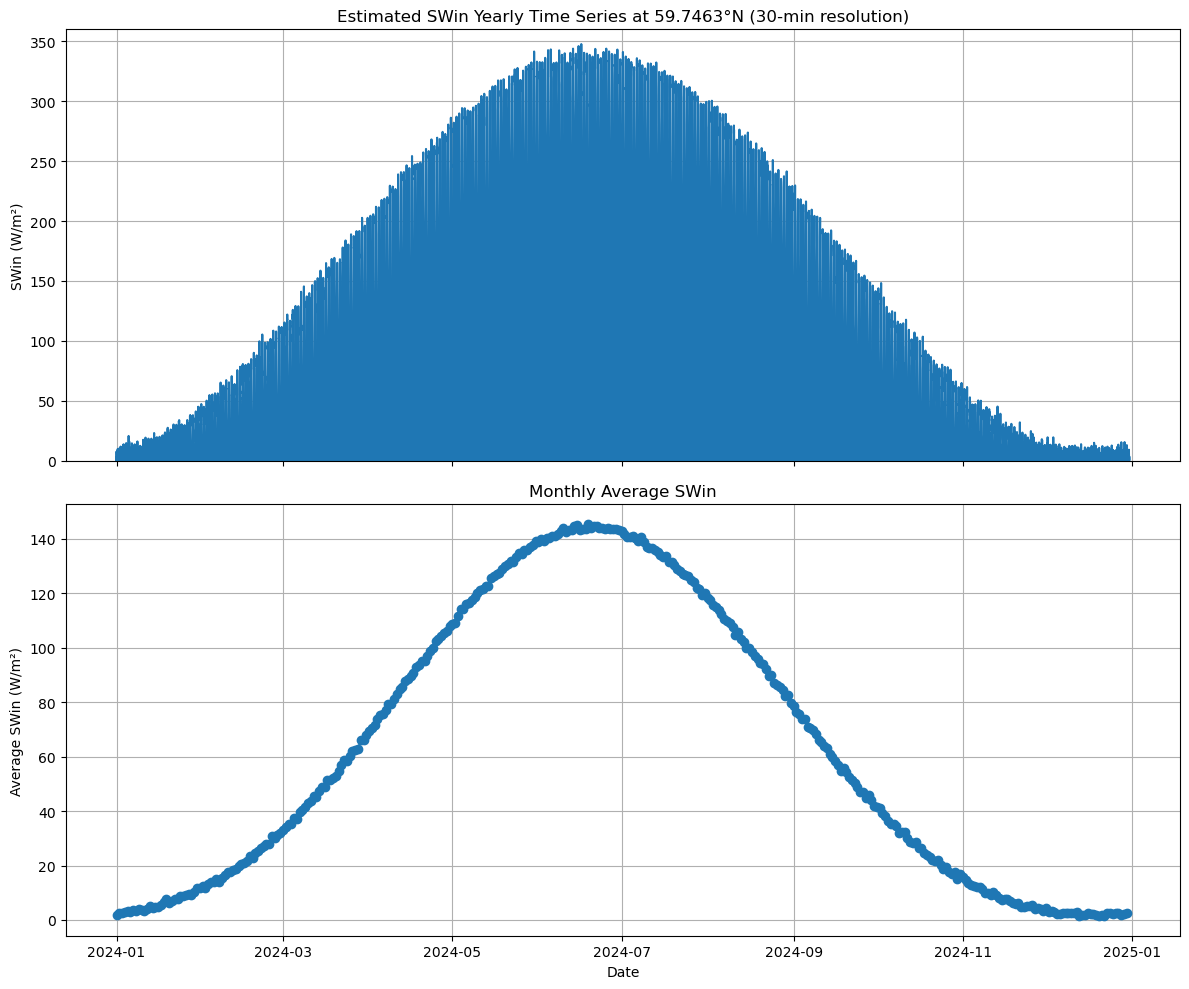

Minimum SWin: 0.00 W/m²
Maximum SWin: 347.71 W/m²
Mean SWin: 63.91 W/m²

Monthly Averages:
                swin
datetime            
2024-01-01  1.694363
2024-01-02  2.426242
2024-01-03  2.489144
2024-01-04  2.943166
2024-01-05  3.347506
...              ...
2024-12-26  2.731553
2024-12-27  2.392815
2024-12-28  1.926505
2024-12-29  2.321257
2024-12-30  2.641343

[365 rows x 1 columns]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

def estimate_swin(day_of_year, hour, latitude):
    max_swin = 1200  # W/m²
    annual_factor = np.cos(2 * np.pi * (day_of_year - 172) / 365) * 0.5 + 0.5
    day_length = 12 + 4 * np.sin(2 * np.pi * (day_of_year - 80) / 365)
    sunrise = 12 - day_length / 2
    sunset = 12 + day_length / 2
    
    if sunrise <= hour <= sunset:
        diurnal_factor = np.sin(np.pi * (hour - sunrise) / (sunset - sunrise))
        swin = max_swin * annual_factor * diurnal_factor
    else:
        swin = 0
    
    lat_factor = np.cos(np.radians(latitude - 45))
    swin *= lat_factor
    return max(min(swin, 350), 0)

# Set up the time series
start_date = datetime(2024, 1, 1)
time_delta = timedelta(minutes=30)
dates = [start_date + i * time_delta for i in range(365 * 48)]

# Generate SWin estimates
latitude = 59.7463
swin_estimates = []

for date in dates:
    day_of_year = date.timetuple().tm_yday
    hour = date.hour + date.minute / 60
    swin_estimates.append(estimate_swin(day_of_year, hour, latitude))

# Add random variation
np.random.seed(42)
variation = np.random.normal(0, 5, len(swin_estimates))
#swin_with_variation = np.clip(np.array(swin_estimates) + variation, 0, 350)

# Create a DataFrame
df = pd.DataFrame({'datetime': dates, 'swin': swin_with_variation})
df.set_index('datetime', inplace=True)

# Calculate monthly averages
monthly_avg = df.resample('D').mean()

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot full time series
ax1.plot(df.index, df['swin'])
ax1.set_title(f"Estimated SWin Yearly Time Series at {latitude}°N (30-min resolution)")
ax1.set_ylabel("SWin (W/m²)")
ax1.set_ylim(0, 360)
ax1.grid(True)

# Plot monthly averages
ax2.plot(monthly_avg.index, monthly_avg['swin'], marker='o')
ax2.set_title("Monthly Average SWin")
ax2.set_xlabel("Date")
ax2.set_ylabel("Average SWin (W/m²)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Minimum SWin: {df['swin'].min():.2f} W/m²")
print(f"Maximum SWin: {df['swin'].max():.2f} W/m²")
print(f"Mean SWin: {df['swin'].mean():.2f} W/m²")

# Print monthly averages
print("\nMonthly Averages:")
print(monthly_avg)

/var/folders/n2/729vncyx06jfhjr9v_2qc25r0000gn/T/ipykernel_15416/2766381605.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M').mean()


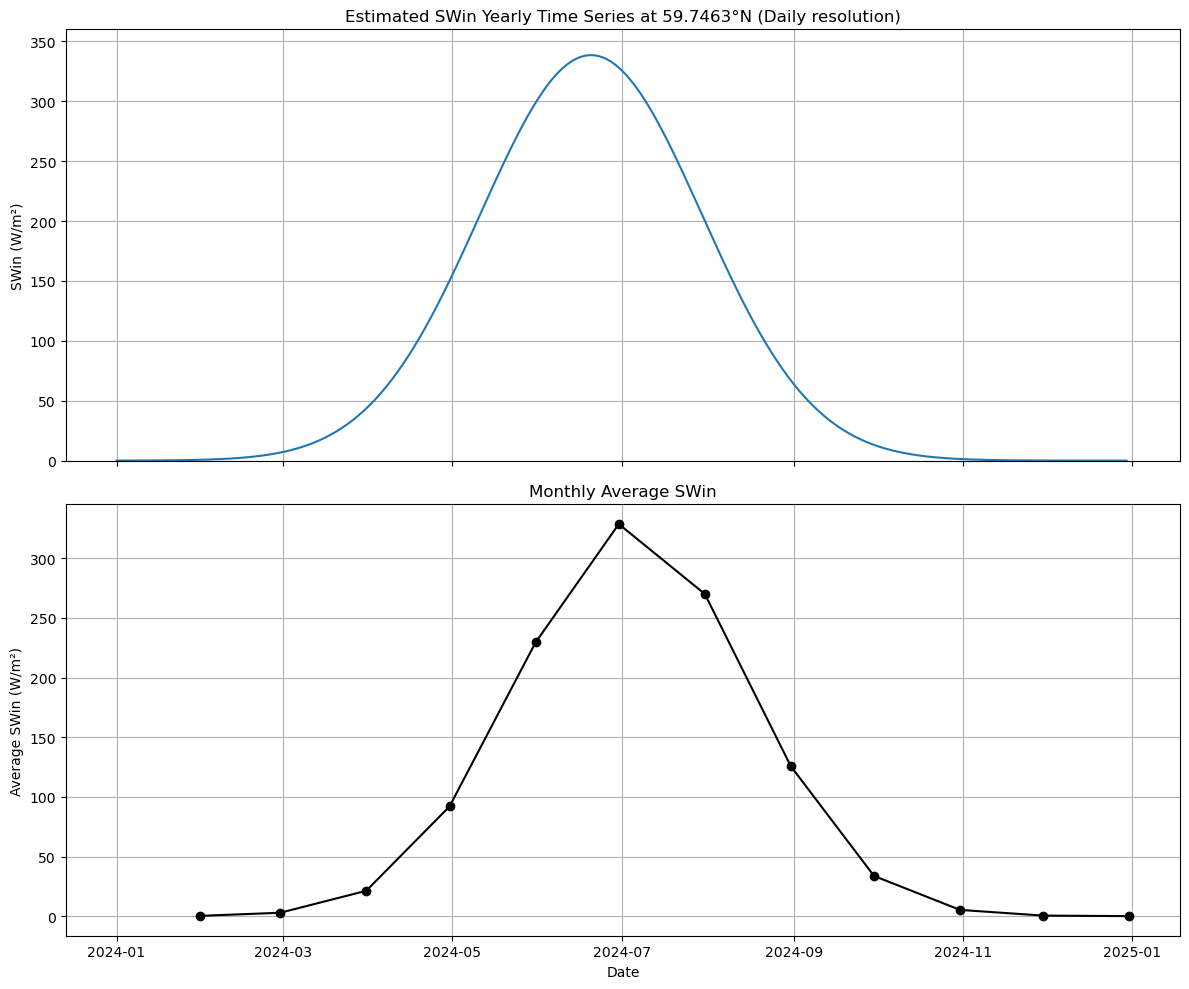

Minimum SWin: 0.00 W/m²
Maximum SWin: 338.47 W/m²
Mean SWin: 92.98 W/m²

Monthly Averages:
                  swin
datetime              
2024-01-31    0.233015
2024-02-29    2.847598
2024-03-31   21.266015
2024-04-30   91.966439
2024-05-31  229.423419
2024-06-30  328.721085
2024-07-31  270.094336
2024-08-31  125.669860
2024-09-30   33.660634
2024-10-31    5.224682
2024-11-30    0.453345
2024-12-31    0.023909


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

def estimate_swin(day_of_year, latitude):
    # Parameters to shape the curve
    peak_swin = 350  # Maximum SWin in W/m²
    winter_min_swin = 0  # Minimum SWin in winter

    # Generate a sharp peak in the middle of the year using a Gaussian function
    mid_year_peak = 172  # Around day 172 for peak in Northern Hemisphere summer
    width = 40  # Controls width of the peak, adjust if needed

    # Gaussian-based function for SWin with latitude adjustment
    swin = peak_swin * np.exp(-((day_of_year - mid_year_peak) ** 2) / (2 * (width ** 2)))

    # Adjust for latitude; high latitudes will reduce the overall values
    lat_factor = np.cos(np.radians(latitude - 45))
    swin *= lat_factor

    # Ensure SWin does not fall below winter minimum
    swin = max(swin, winter_min_swin)

    return swin

# Set up the time series (one value per day for a full year)
start_date = datetime(2024, 1, 1)
time_delta = timedelta(days=1)
dates = [start_date + i * time_delta for i in range(365)]

# Generate SWin estimates
latitude = 59.7463  # High-latitude example
swin_estimates = []

for date in dates:
    day_of_year = date.timetuple().tm_yday
    swin_estimates.append(estimate_swin(day_of_year, latitude))

# Create a DataFrame
df = pd.DataFrame({'datetime': dates, 'swin': swin_estimates})
df.set_index('datetime', inplace=True)

# Calculate monthly averages
monthly_avg = df.resample('M').mean()

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot full time series
ax1.plot(df.index, df['swin'])
ax1.set_title(f"Estimated SWin Yearly Time Series at {latitude}°N (Daily resolution)")
ax1.set_ylabel("SWin (W/m²)")
ax1.set_ylim(0, 360)
ax1.grid(True)

# Plot monthly averages in black to match the reference style
ax2.plot(monthly_avg.index, monthly_avg['swin'], marker='o', color='black')
ax2.set_title("Monthly Average SWin")
ax2.set_xlabel("Date")
ax2.set_ylabel("Average SWin (W/m²)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Minimum SWin: {df['swin'].min():.2f} W/m²")
print(f"Maximum SWin: {df['swin'].max():.2f} W/m²")
print(f"Mean SWin: {df['swin'].mean():.2f} W/m²")

# Print monthly averages
print("\nMonthly Averages:")
print(monthly_avg)


/var/folders/n2/729vncyx06jfhjr9v_2qc25r0000gn/T/ipykernel_15416/4085778965.py:62: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M').mean()


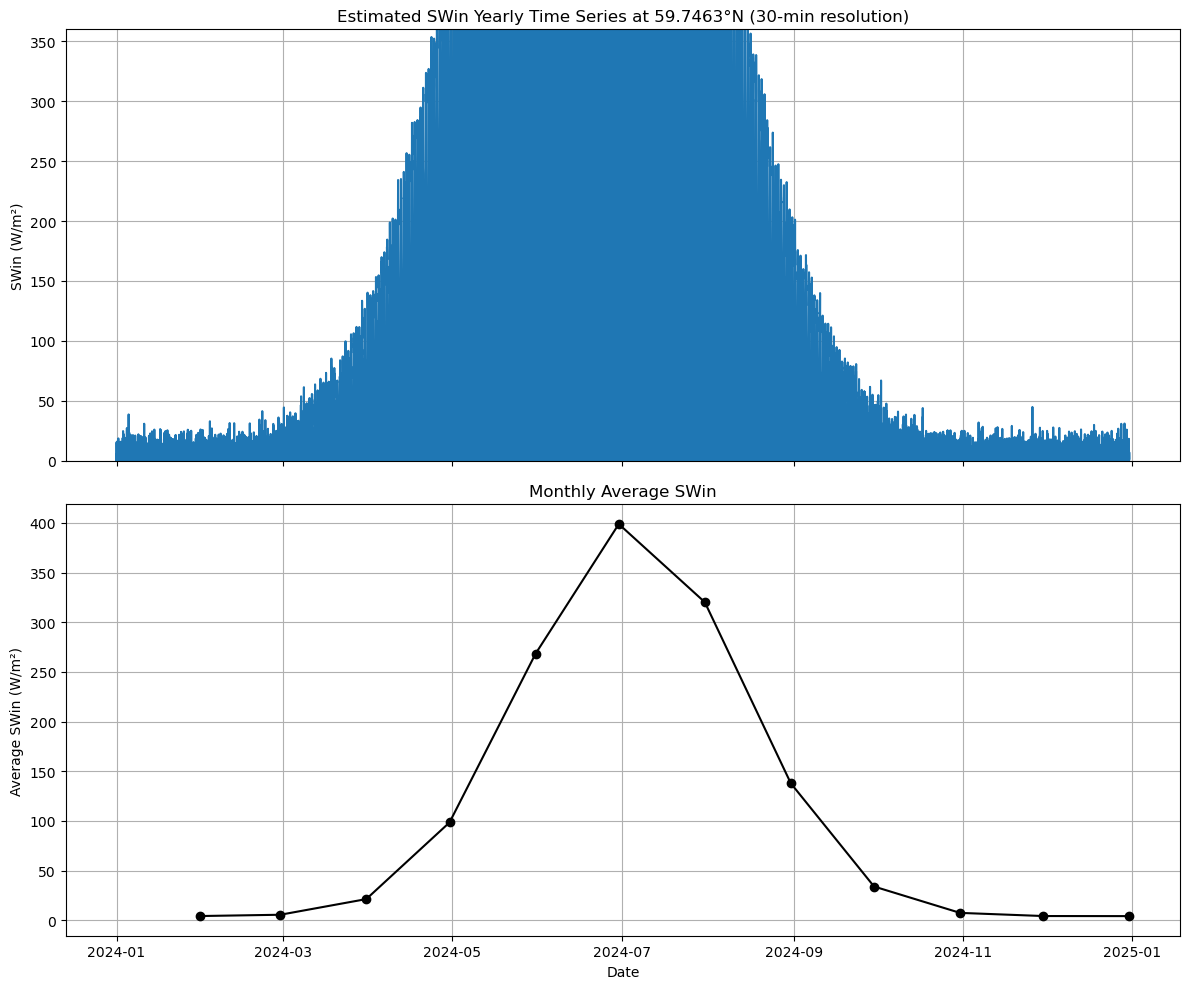

Minimum SWin: 0.00 W/m²
Maximum SWin: 980.14 W/m²
Mean SWin: 109.26 W/m²

Monthly Averages:
                  swin
datetime              
2024-01-31    4.223506
2024-02-29    5.522227
2024-03-31   21.281437
2024-04-30   98.431511
2024-05-31  268.230864
2024-06-30  398.799258
2024-07-31  320.153778
2024-08-31  137.827328
2024-09-30   33.928373
2024-10-31    7.401795
2024-11-30    4.227580
2024-12-31    4.145496


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

def estimate_swin(day_of_year, hour, latitude):
    # Parameters to shape the curve
    peak_swin = 1000  # Maximum SWin in W/m²
    winter_min_swin = 0  # Minimum SWin in winter

    # Generate a sharp peak in the middle of the year using a Gaussian function
    mid_year_peak = 172  # Around day 172 for peak in Northern Hemisphere summer
    width = 40  # Controls width of the peak, adjust if needed

    # Gaussian-based function for SWin with latitude adjustment
    daily_max_swin = peak_swin * np.exp(-((day_of_year - mid_year_peak) ** 2) / (2 * (width ** 2)))

    # Adjust for latitude; high latitudes will reduce the overall values
    lat_factor = np.cos(np.radians(latitude - 45))
    daily_max_swin *= lat_factor

    # Ensure daily max SWin does not fall below winter minimum
    daily_max_swin = max(daily_max_swin, winter_min_swin)

    # Add diurnal cycle
    day_length = 12 + 4 * np.sin(2 * np.pi * (day_of_year - 80) / 365)  # Approximate day length
    sunrise = 12 - day_length / 2
    sunset = 12 + day_length / 2

    if sunrise <= hour <= sunset:
        diurnal_factor = np.sin(np.pi * (hour - sunrise) / (sunset - sunrise))
        swin = daily_max_swin * diurnal_factor
    else:
        swin = 0

    return swin

# Set up the time series (30-minute resolution for a full year)
start_date = datetime(2024, 1, 1)
time_delta = timedelta(minutes=30)
dates = [start_date + i * time_delta for i in range(365 * 48)]  # 48 30-minute intervals per day

# Generate SWin estimates
latitude = 59.7463  # High-latitude example
swin_estimates = []

for date in dates:
    day_of_year = date.timetuple().tm_yday
    hour = date.hour + date.minute / 60
    swin_estimates.append(estimate_swin(day_of_year, hour, latitude))

# Add random variation to simulate fluctuations
np.random.seed(42)  # For reproducibility
variation = np.random.normal(0, 10, len(swin_estimates))  # Mean 0, standard deviation 10 W/m²
swin_with_variation = np.clip(np.array(swin_estimates) + variation, 0, 1000)

# Create a DataFrame
df = pd.DataFrame({'datetime': dates, 'swin': swin_with_variation})
df.set_index('datetime', inplace=True)

# Calculate monthly averages
monthly_avg = df.resample('M').mean()

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot full time series
ax1.plot(df.index, df['swin'])
ax1.set_title(f"Estimated SWin Yearly Time Series at {latitude}°N (30-min resolution)")
ax1.set_ylabel("SWin (W/m²)")
ax1.set_ylim(0, 360)
ax1.grid(True)

# Plot monthly averages in black to match the reference style
ax2.plot(monthly_avg.index, monthly_avg['swin'], marker='o', color='black')
ax2.set_title("Monthly Average SWin")
ax2.set_xlabel("Date")
ax2.set_ylabel("Average SWin (W/m²)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Minimum SWin: {df['swin'].min():.2f} W/m²")
print(f"Maximum SWin: {df['swin'].max():.2f} W/m²")
print(f"Mean SWin: {df['swin'].mean():.2f} W/m²")

# Print monthly averages
print("\nMonthly Averages:")
print(monthly_avg)

/var/folders/n2/729vncyx06jfhjr9v_2qc25r0000gn/T/ipykernel_15416/3243908317.py:62: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M').mean()


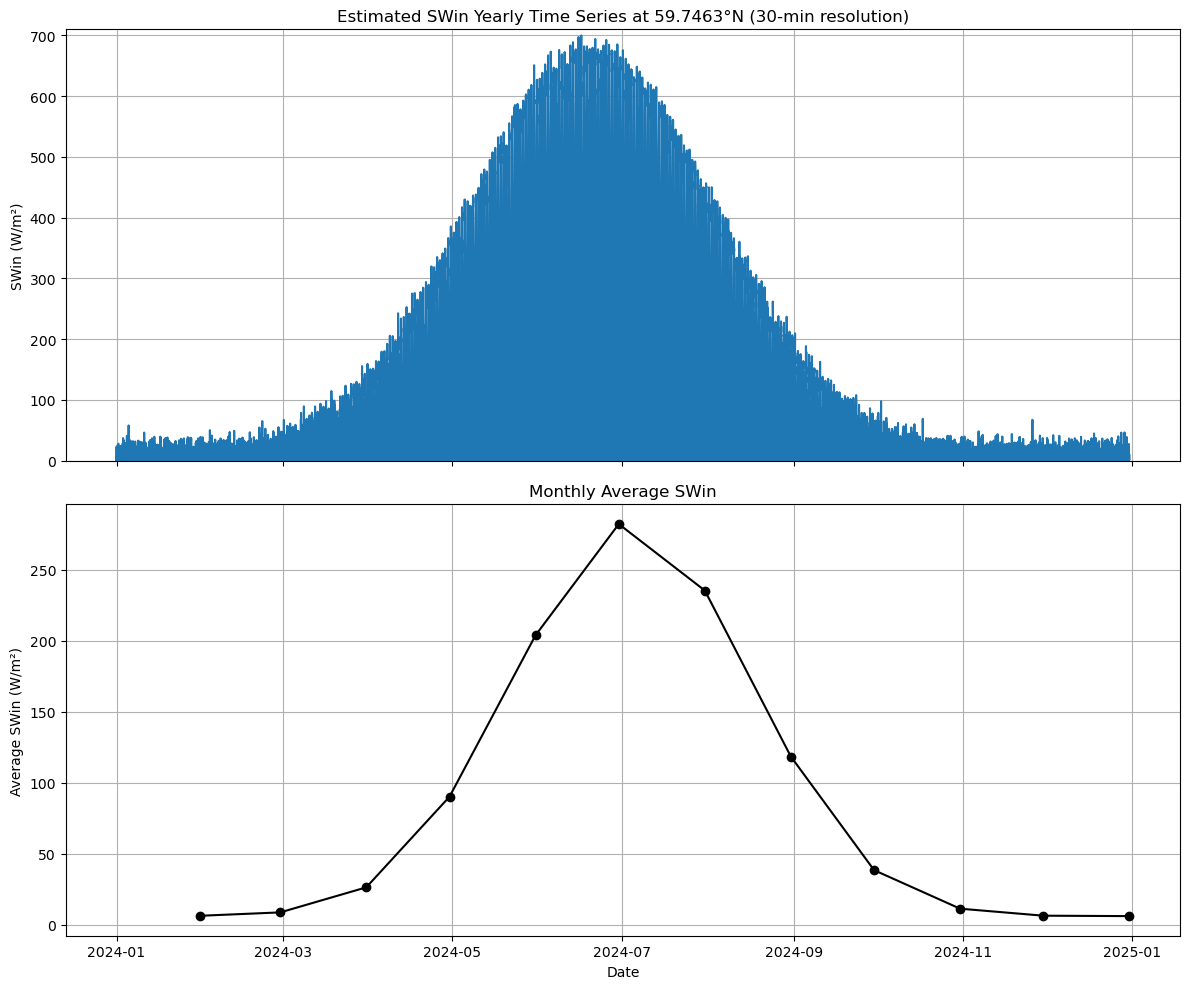

Minimum SWin: 0.00 W/m²
Maximum SWin: 700.00 W/m²
Mean SWin: 86.70 W/m²

Monthly Averages:
                  swin
datetime              
2024-01-31    6.473055
2024-02-29    8.867841
2024-03-31   26.495815
2024-04-30   90.305416
2024-05-31  203.911719
2024-06-30  282.187661
2024-07-31  235.414350
2024-08-31  118.585959
2024-09-30   38.596610
2024-10-31   11.477111
2024-11-30    6.545576
2024-12-31    6.243347

Maximum Monthly Average: 282.19 W/m²


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

def estimate_swin(day_of_year, hour, latitude):
    # Parameters to shape the curve
    peak_swin = 700  # Adjusted peak to achieve ~300 W/m² monthly max
    winter_min_swin = 0  # Minimum SWin in winter

    # Generate a sharp peak in the middle of the year using a Gaussian function
    mid_year_peak = 172  # Around day 172 for peak in Northern Hemisphere summer
    width = 45  # Adjusted for a slightly wider peak

    # Gaussian-based function for SWin with latitude adjustment
    daily_max_swin = peak_swin * np.exp(-((day_of_year - mid_year_peak) ** 2) / (2 * (width ** 2)))

    # Adjust for latitude; high latitudes will reduce the overall values
    lat_factor = np.cos(np.radians(latitude - 45))
    daily_max_swin *= lat_factor

    # Ensure daily max SWin does not fall below winter minimum
    daily_max_swin = max(daily_max_swin, winter_min_swin)

    # Add diurnal cycle
    day_length = 12 + 4 * np.sin(2 * np.pi * (day_of_year - 80) / 365)  # Approximate day length
    sunrise = 12 - day_length / 2
    sunset = 12 + day_length / 2

    if sunrise <= hour <= sunset:
        diurnal_factor = np.sin(np.pi * (hour - sunrise) / (sunset - sunrise))
        swin = daily_max_swin * diurnal_factor
    else:
        swin = 0

    return swin

# Set up the time series (30-minute resolution for a full year)
start_date = datetime(2024, 1, 1)
time_delta = timedelta(minutes=30)
dates = [start_date + i * time_delta for i in range(365 * 48)]  # 48 30-minute intervals per day

# Generate SWin estimates
latitude = 59.7463  # High-latitude example
swin_estimates = []

for date in dates:
    day_of_year = date.timetuple().tm_yday
    hour = date.hour + date.minute / 60
    swin_estimates.append(estimate_swin(day_of_year, hour, latitude))

# Add random variation to simulate fluctuations
np.random.seed(42)  # For reproducibility
variation = np.random.normal(0, 15, len(swin_estimates))  # Mean 0, standard deviation 10 W/m²
swin_with_variation = np.clip(np.array(swin_estimates) + variation, 0, 700)

# Create a DataFrame
df = pd.DataFrame({'datetime': dates, 'swin': swin_with_variation})
df.set_index('datetime', inplace=True)

# Calculate monthly averages
monthly_avg = df.resample('M').mean()

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot full time series
ax1.plot(df.index, df['swin'])
ax1.set_title(f"Estimated SWin Yearly Time Series at {latitude}°N (30-min resolution)")
ax1.set_ylabel("SWin (W/m²)")
ax1.set_ylim(0, 710)
ax1.grid(True)

# Plot monthly averages in black to match the reference style
ax2.plot(monthly_avg.index, monthly_avg['swin'], marker='o', color='black')
ax2.set_title("Monthly Average SWin")
ax2.set_xlabel("Date")
ax2.set_ylabel("Average SWin (W/m²)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Minimum SWin: {df['swin'].min():.2f} W/m²")
print(f"Maximum SWin: {df['swin'].max():.2f} W/m²")
print(f"Mean SWin: {df['swin'].mean():.2f} W/m²")

# Print monthly averages
print("\nMonthly Averages:")
print(monthly_avg)
print(f"\nMaximum Monthly Average: {monthly_avg['swin'].max():.2f} W/m²")